In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# Query sentences:
queries = ['bath', 
          'beach',
          'location']

In [3]:
corpus = ['Perfect plan B for our beach wedding that we couldn’t have.' #beach
         ,'Staff were AMAZING - so friendly and accommodating.' # no tag
         ,'All apartments with a pool view Ten minute walk to the centre of town, very friendly, helpful and flexible staff and good clean rooms and comfy beds'# location
         ,'We had a 2 bedroom suite with a hot tub.' #bath
         ,'Overall the room was very clean, as were the bathrooms.'#bath
         ,'The property is very close to everything' #location
         ,'The beach is less than a two minute walk as-well as restaurants and bars and some small shops so it’s ideally placed .' #beach or location
         ,'The location only 5 min drive from a shopping mall with restaurants.' #location
         ]

In [4]:
import tensorflow_hub as hub
module = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedder = hub.load(module)
corpus_embeddings = embedder(corpus)

In [5]:
import scipy
import math

def hub_similarity(query, text, embedder):
    query_embedding = tf.nn.l2_normalize(embedder(tf.constant([query])), axis=1)
    text_embedding = tf.nn.l2_normalize(embedder(tf.constant([text])), axis=1)
    
    cosine_similarities = tf.reduce_sum(tf.multiply(query_embedding, text_embedding ), axis=1)
    clip_cosine_similarities = tf.clip_by_value(cosine_similarities, -1.0, 1.0)
    scores = 1.0 - tf.acos(clip_cosine_similarities) / math.pi
    
    return scores

In [6]:
import tensorflow as tf
from operator import itemgetter
top_k = 3

for query in queries:
    scores = []
    for text in corpus:
        score = hub_similarity(query, text, embedder)
        scores.append(score.numpy()[0])
    results = zip(corpus, scores)
    top_results = sorted(results, key= itemgetter(1), reverse = True)[0:top_k]

    print("\n\n======================\n\n")
    print("Query:", query)
    print("\nTop 3 most similar sentences in corpus:")

    for text, score in top_results:
        print(text, "(Score: %.4f)" % (score))





Query: bath

Top 3 most similar sentences in corpus:
We had a 2 bedroom suite with a hot tub. (Score: 0.5843)
Overall the room was very clean, as were the bathrooms. (Score: 0.5574)
The property is very close to everything (Score: 0.5349)




Query: beach

Top 3 most similar sentences in corpus:
Perfect plan B for our beach wedding that we couldn’t have. (Score: 0.5916)
The beach is less than a two minute walk as-well as restaurants and bars and some small shops so it’s ideally placed . (Score: 0.5753)
The property is very close to everything (Score: 0.5380)




Query: location

Top 3 most similar sentences in corpus:
The property is very close to everything (Score: 0.5513)
The location only 5 min drive from a shopping mall with restaurants. (Score: 0.5367)
The beach is less than a two minute walk as-well as restaurants and bars and some small shops so it’s ideally placed . (Score: 0.5310)


In [7]:
df = pd.DataFrame({'text':corpus, 
                  'label': ['beach','staff','location','bath','bath','location','beach','location']})
df

,text,label
0,Perfect plan B for our beach wedding that we c...,beach
1,Staff were AMAZING - so friendly and accommoda...,staff
2,All apartments with a pool view Ten minute wal...,location
3,We had a 2 bedroom suite with a hot tub.,bath
4,"Overall the room was very clean, as were the b...",bath
5,The property is very close to everything,location
6,The beach is less than a two minute walk as-we...,beach
7,The location only 5 min drive from a shopping ...,location


In [32]:
text = df['text'].tolist()
text_embedding = tf.nn.l2_normalize(embedder(tf.constant(text)), axis=1)

In [33]:
text_embedding 

<tf.Tensor: shape=(8, 512), dtype=float32, numpy=
array([[-0.02992763, -0.01007182,  0.01801983, ..., -0.03203385,
         0.01416638,  0.04188122],
       [-0.08326066,  0.00711939,  0.03198057, ..., -0.06092391,
         0.02511997,  0.01230324],
       [ 0.00713365, -0.02916948, -0.02869286, ...,  0.06301181,
         0.06479787,  0.08371397],
       ...,
       [-0.05674588, -0.00860478, -0.01318681, ..., -0.02272435,
         0.02468883,  0.05523442],
       [-0.07812671, -0.04461333, -0.0065792 , ...,  0.01745429,
        -0.05469334,  0.06564174],
       [-0.01343004,  0.00508374, -0.03574057, ..., -0.04606763,
        -0.04331686, -0.02745518]], dtype=float32)>

In [34]:
import umap
import umap.plot
import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
%%time
mapper = umap.UMAP(n_neighbors=8,
                               n_components=5,
                               metric='cosine').fit(text_embedding)

/opt/conda/lib/python3.7/site-packages/umap/umap_.py:2215: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


CPU times: user 3.7 s, sys: 3.44 s, total: 7.14 s
Wall time: 4.3 s


In [37]:
len(mapper.embedding_)

8

In [61]:
mapper.embedding_.shape

(8, 5)

In [62]:
#df_embedding = pd.DataFrame(list(map(np.ravel, mapper.embedding_)), columns = ['dim1','dim2','dim3','dim4','dim5'])
df_embedding = pd.DataFrame(mapper.embedding_, columns = ['dim1','dim2','dim3','dim4','dim5'])
df_embedding['emd'] = df_embedding.apply(lambda r: tuple(r), axis=1).apply(np.array)
df_embedding

,dim1,dim2,dim3,dim4,dim5,emd
0,2.960057,7.748816,3.610958,-3.918318,0.311885,"[2.960057258605957, 7.748816013336182, 3.61095..."
1,3.025546,8.872066,3.597700,-3.004746,0.259967,"[3.025545597076416, 8.872066497802734, 3.59769..."
2,3.639231,8.900084,4.011639,-3.576865,0.677977,"[3.6392314434051514, 8.900083541870117, 4.0116..."
3,2.553021,8.434787,3.987511,-4.503460,0.283527,"[2.553021192550659, 8.434786796569824, 3.98751..."
4,2.262900,8.778159,3.597315,-3.617911,0.494508,"[2.262899875640869, 8.778159141540527, 3.59731..."
5,2.369797,8.791329,4.558879,-3.777204,0.276829,"[2.3697972297668457, 8.791329383850098, 4.5588..."
6,3.568676,8.285285,4.523750,-3.596047,0.052983,"[3.568676233291626, 8.285284996032715, 4.52375..."
7,3.333349,8.256815,4.465523,-4.288037,0.546908,"[3.3333487510681152, 8.256814956665039, 4.4655..."


In [63]:
df_text_emd = pd.concat([df, df_embedding], axis=1)
df_text_emd

,text,label,dim1,dim2,dim3,dim4,dim5,emd
0,Perfect plan B for our beach wedding that we c...,beach,2.960057,7.748816,3.610958,-3.918318,0.311885,"[2.960057258605957, 7.748816013336182, 3.61095..."
1,Staff were AMAZING - so friendly and accommoda...,staff,3.025546,8.872066,3.597700,-3.004746,0.259967,"[3.025545597076416, 8.872066497802734, 3.59769..."
2,All apartments with a pool view Ten minute wal...,location,3.639231,8.900084,4.011639,-3.576865,0.677977,"[3.6392314434051514, 8.900083541870117, 4.0116..."
3,We had a 2 bedroom suite with a hot tub.,bath,2.553021,8.434787,3.987511,-4.503460,0.283527,"[2.553021192550659, 8.434786796569824, 3.98751..."
4,"Overall the room was very clean, as were the b...",bath,2.262900,8.778159,3.597315,-3.617911,0.494508,"[2.262899875640869, 8.778159141540527, 3.59731..."
5,The property is very close to everything,location,2.369797,8.791329,4.558879,-3.777204,0.276829,"[2.3697972297668457, 8.791329383850098, 4.5588..."
6,The beach is less than a two minute walk as-we...,beach,3.568676,8.285285,4.523750,-3.596047,0.052983,"[3.568676233291626, 8.285284996032715, 4.52375..."
7,The location only 5 min drive from a shopping ...,location,3.333349,8.256815,4.465523,-4.288037,0.546908,"[3.3333487510681152, 8.256814956665039, 4.4655..."


<AxesSubplot:xlabel='dim1', ylabel='dim2'>

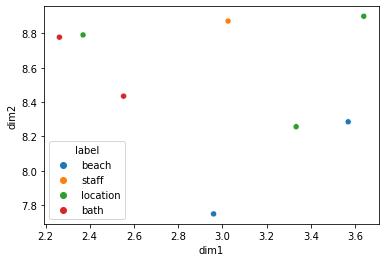

In [64]:
import seaborn as sns
sns.scatterplot(data=df_text_emd, x="dim1", y="dim2", hue="label")

In [127]:
#input_list = df_text_emd['text'].tolist()
input_list = ['Perfect plan B for our beach wedding that we couldn’t have.']
for i in input_list:
    scores = []
    x = df_text_emd[df_text_emd['text']== i]['emd'].values[0]
    data = df_text_emd[df_text_emd['text']!= i]
    for output in data['text'].tolist():
        e = data[data['text']==output]['emd'].values[0]
        score = 1 - spatial.distance.cosine(x, e)
        scores.append(score)
    results = zip(data['text'].tolist(), scores)
    top_results = sorted(results, key= itemgetter(1), reverse = True)[0:top_k]

    print("\n\n======================\n\n")
    print("Input Text:", i)
    print("\nTop 3 most similar sentences in corpus:")

    for output, score in top_results:
        print(output, "(Score: %.4f)" % (score))





Input Text: Perfect plan B for our beach wedding that we couldn’t have.

Top 3 most similar sentences in corpus:
The location only 5 min drive from a shopping mall with restaurants. (Score: 0.9985)
We had a 2 bedroom suite with a hot tub. (Score: 0.9978)
All apartments with a pool view Ten minute walk to the centre of town, very friendly, helpful and flexible staff and good clean rooms and comfy beds (Score: 0.9962)


In [104]:
i = input_list = df_text_emd['text'].tolist()[0]
scores = []
x = df_text_emd[df_text_emd['text']== i]['emd'].values[0]
x

array([ 2.96005726,  7.74881601,  3.6109581 , -3.91831827,  0.31188452])

In [118]:
data = df_text_emd[df_text_emd['text']!= i]
for output in data['text'].tolist():
    e = data[data['text']==output]['emd'].values[0]
    print(output)
    score = 1 - spatial.distance.cosine(x, e)
    print(score)
    scores.append(score)

Staff were AMAZING - so friendly and accommodating.
0.9916868569894873
All apartments with a pool view Ten minute walk to the centre of town, very friendly, helpful and flexible staff and good clean rooms and comfy beds
0.9962201368617543
We had a 2 bedroom suite with a hot tub.
0.9977889879908113
Overall the room was very clean, as were the bathrooms.
0.9933475804819905
The property is very close to everything
0.9936813106165806
The beach is less than a two minute walk as-well as restaurants and bars and some small shops so it’s ideally placed .
0.9955509856950341
The location only 5 min drive from a shopping mall with restaurants.
0.9984608985761659
